In [1]:
from qsprpred.data.storage.tabular.simple import PandasChemStore
from qsprpred.data.storage.tabular.hierarchical import PandasRepresentationStore
from spock.storage.tabular import SpockStorage
from graphein.molecule import plotly_molecular_graph
from qsprpred.plotting.grid_visualizers import table_to_grid
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from Bio import PDB
import os
import nglview

In [2]:
# load the correct storages from the data folder
store = SpockStorage.fromFile('../Data/temp/SpockStorage/meta.json') #(add an extra . in line 68 of the json to resolve pathing issues)
library = PandasChemStore.fromFile('../Data/temp/ChemStorage/meta.json')
representation_store = PandasRepresentationStore.fromFile('../Data/temp/ProtomerStorage/ProtomerStorage/ProtomerStorage_representations/meta.json')

In [3]:
# Initialize mol without printing anything
for mol in library:
    mol.as_rd_mol()
    break

In [4]:
# initialize mol_representation without printing anything
for mol in representation_store:
    if mol.representations and len(mol.representations) > 1:
        break

In [5]:
# get summary to validate the data
store.getSummary()

,Path,Name,Molecules,Targets,Poses
0,./Data/temp/SpockStorage,SpockStorage,19,1,290


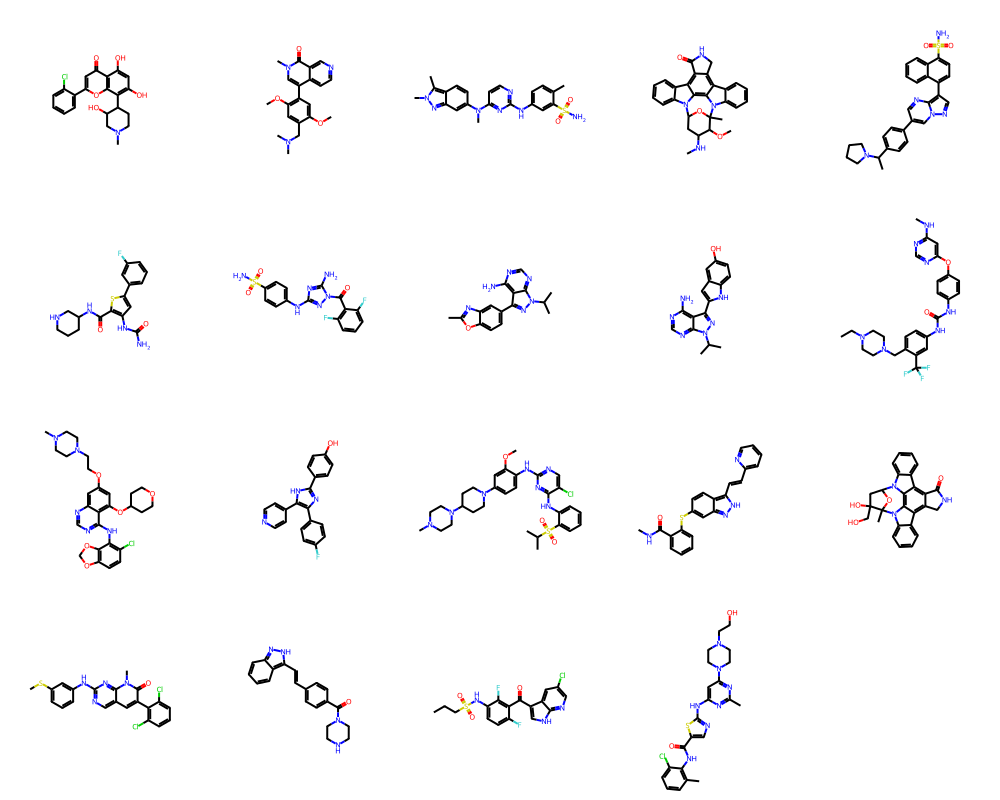

In [6]:
# visualise 2D representation of the molecules
table_to_grid(library)

In [7]:
# get the DF of the store
df = store.getDF().reset_index(drop=True)

In [8]:
# get the df from the promoterstorage
df2 = representation_store.getDF().reset_index(drop=True)

In [9]:
# merge df with df2 on shared column
merged_df = pd.merge(df, df2, left_on='parent_id', right_on='ProtomerStorage_representations_ID', how='inner')
merged_df = merged_df[['parent_id_y', 'ProtomerStorage_representations_ID', 'sdf_x', 'vina_energy_total', 'SMILES_y']]
merged_df = merged_df.rename(columns={'parent_id_y': 'inchikey', 'sdf_x': 'sdf', 'SMILES_y': 'SMILES'})
merged_df['vina_energy_total'] = pd.to_numeric(merged_df['vina_energy_total'], errors='coerce')
merged_df

,inchikey,ProtomerStorage_representations_ID,sdf,vina_energy_total,SMILES
0,JUUFLLKHNYWHKP-UHFFFAOYSA-N,ProtomerStorage_representations_library_9e8bfb...,\n RDKit 3D\n\n 39 42 0 0 0 0...,-8.022,Cc1nc2cc(-c3nn(C(C)C)c4ncnc(N)c34)ccc2o1
1,JUUFLLKHNYWHKP-UHFFFAOYSA-N,ProtomerStorage_representations_library_9e8bfb...,\n RDKit 3D\n\n 39 42 0 0 0 0...,-7.677,Cc1nc2cc(-c3nn(C(C)C)c4ncnc(N)c34)ccc2o1
2,JUUFLLKHNYWHKP-UHFFFAOYSA-N,ProtomerStorage_representations_library_9e8bfb...,\n RDKit 3D\n\n 39 42 0 0 0 0...,-7.641,Cc1nc2cc(-c3nn(C(C)C)c4ncnc(N)c34)ccc2o1
3,JUUFLLKHNYWHKP-UHFFFAOYSA-N,ProtomerStorage_representations_library_9e8bfb...,\n RDKit 3D\n\n 39 42 0 0 0 0...,-7.254,Cc1nc2cc(-c3nn(C(C)C)c4ncnc(N)c34)ccc2o1
4,JUUFLLKHNYWHKP-UHFFFAOYSA-N,ProtomerStorage_representations_library_9e8bfb...,\n RDKit 3D\n\n 39 42 0 0 0 0...,-7.235,Cc1nc2cc(-c3nn(C(C)C)c4ncnc(N)c34)ccc2o1
...,...,...,...,...,...
285,QQWUGDVOUVUTOY-UHFFFAOYSA-N,ProtomerStorage_representations_library_d424a5...,\n RDKit 3D\n\n 82 86 0 0 0 0...,-1.302,COc1cc(N2CCC(N3CCN(C)CC3)CC2)ccc1Nc1ncc(Cl)c(N...
286,QQWUGDVOUVUTOY-UHFFFAOYSA-N,ProtomerStorage_representations_library_d424a5...,\n RDKit 3D\n\n 82 86 0 0 0 0...,1.058,COc1cc(N2CCC(N3CCN(C)CC3)CC2)ccc1Nc1ncc(Cl)c(N...
287,QQWUGDVOUVUTOY-UHFFFAOYSA-N,ProtomerStorage_representations_library_d424a5...,\n RDKit 3D\n\n 83 87 0 0 0 0...,2.385,COc1cc(N2CCC(N3CC[NH+](C)CC3)CC2)ccc1Nc1ncc(Cl...
288,QQWUGDVOUVUTOY-UHFFFAOYSA-N,ProtomerStorage_representations_library_d424a5...,\n RDKit 3D\n\n 83 87 0 0 0 0...,3.841,COc1cc(N2CCC(N3CC[NH+](C)CC3)CC2)ccc1Nc1ncc(Cl...


In [10]:
# Group by 'inchikey', find the 2 rows with the lowest 'vina_energy_total' for each group
grouped_df = merged_df.loc[merged_df.groupby('inchikey')['vina_energy_total'].nsmallest(1).index.get_level_values(1)]
grouped_df = grouped_df.sort_values(by='vina_energy_total', ascending=True)
grouped_df

,inchikey,ProtomerStorage_representations_ID,sdf,vina_energy_total,SMILES
52,IAYGCINLNONXHY-UHFFFAOYSA-N,ProtomerStorage_representations_library_e7f5b1...,\n RDKit 3D\n\n 45 47 0 0 0 0...,-9.468,NC(=O)Nc1cc(-c2cccc(F)c2)sc1C(=O)NC1CCC[NH2+]C1
126,CUIHSIWYWATEQL-UHFFFAOYSA-N,ProtomerStorage_representations_library_a75511...,\n RDKit 3D\n\n 53 56 0 0 0 0...,-9.462,Cc1ccc(Nc2nccc(N(C)c3ccc4c(C)n(C)nc4c3)n2)cc1S...
108,QHKYPYXTTXKZST-UHFFFAOYSA-N,ProtomerStorage_representations_library_b01805...,\n RDKit 3D\n\n 38 41 0 0 0 0...,-8.946,[O-]c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc3)[nH]2...
176,BIIVYFLTOXDAOV-UHFFFAOYSA-N,ProtomerStorage_representations_library_7bb6c3...,\n RDKit 3D\n\n 47 50 0 0 0 0...,-8.768,CN1CCC(c2c([O-])cc(O)c3c(=O)cc(-c4ccccc4Cl)oc2...
18,MFAQYJIYDMLAIM-UHFFFAOYSA-N,ProtomerStorage_representations_library_857f78...,\n RDKit 3D\n\n 38 41 0 0 0 0...,-8.681,CC(C)n1nc(-c2cc3cc([O-])ccc3[nH]2)c2c(N)ncnc21
202,YYLKKYCXAOBSRM-UHFFFAOYSA-N,ProtomerStorage_representations_library_d27905...,\n RDKit 3D\n\n 45 48 0 0 0 0...,-8.597,O=C(c1ccc(C=Cc2[n-]nc3ccccc23)cc1)[NH+]1CCNCC1
277,OUKYUETWWIPKQR-UHFFFAOYSA-N,ProtomerStorage_representations_library_078573...,\n RDKit 3D\n\n 71 76 0 0 0 0...,-8.283,C[NH+]1CCN(CCOc2cc(OC3CCOCC3)c3c(Nc4c(Cl)ccc5c...
137,RITAVMQDGBJQJZ-UHFFFAOYSA-N,ProtomerStorage_representations_library_4d5071...,\n RDKit 3D\n\n 46 49 0 0 0 0...,-8.282,CNC(=O)c1ccccc1Sc1ccc2c(C=Cc3ccccn3)[nH]nc2c1
193,YZDJQTHVDDOVHR-UHFFFAOYSA-N,ProtomerStorage_representations_library_44ca33...,\n RDKit 3D\n\n 41 43 0 0 0 0...,-8.151,CCCS(=O)(=O)Nc1ccc(F)c(C(=O)c2c[nH]c3ncc(Cl)cc...
68,BJFSUDWKXGMUKA-UHFFFAOYSA-N,ProtomerStorage_representations_library_b92bb3...,\n RDKit 3D\n\n 49 51 0 0 0 0...,-8.060,COc1cc(-c2cn(C)c(=O)c3cnccc23)c(OC)cc1CN(C)C


In [11]:
# remove the rows where vina_energy_total > -7
filtered_df = grouped_df[grouped_df['vina_energy_total'] <= -4.5]
filtered_df

,inchikey,ProtomerStorage_representations_ID,sdf,vina_energy_total,SMILES
52,IAYGCINLNONXHY-UHFFFAOYSA-N,ProtomerStorage_representations_library_e7f5b1...,\n RDKit 3D\n\n 45 47 0 0 0 0...,-9.468,NC(=O)Nc1cc(-c2cccc(F)c2)sc1C(=O)NC1CCC[NH2+]C1
126,CUIHSIWYWATEQL-UHFFFAOYSA-N,ProtomerStorage_representations_library_a75511...,\n RDKit 3D\n\n 53 56 0 0 0 0...,-9.462,Cc1ccc(Nc2nccc(N(C)c3ccc4c(C)n(C)nc4c3)n2)cc1S...
108,QHKYPYXTTXKZST-UHFFFAOYSA-N,ProtomerStorage_representations_library_b01805...,\n RDKit 3D\n\n 38 41 0 0 0 0...,-8.946,[O-]c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc3)[nH]2...
176,BIIVYFLTOXDAOV-UHFFFAOYSA-N,ProtomerStorage_representations_library_7bb6c3...,\n RDKit 3D\n\n 47 50 0 0 0 0...,-8.768,CN1CCC(c2c([O-])cc(O)c3c(=O)cc(-c4ccccc4Cl)oc2...
18,MFAQYJIYDMLAIM-UHFFFAOYSA-N,ProtomerStorage_representations_library_857f78...,\n RDKit 3D\n\n 38 41 0 0 0 0...,-8.681,CC(C)n1nc(-c2cc3cc([O-])ccc3[nH]2)c2c(N)ncnc21
202,YYLKKYCXAOBSRM-UHFFFAOYSA-N,ProtomerStorage_representations_library_d27905...,\n RDKit 3D\n\n 45 48 0 0 0 0...,-8.597,O=C(c1ccc(C=Cc2[n-]nc3ccccc23)cc1)[NH+]1CCNCC1
277,OUKYUETWWIPKQR-UHFFFAOYSA-N,ProtomerStorage_representations_library_078573...,\n RDKit 3D\n\n 71 76 0 0 0 0...,-8.283,C[NH+]1CCN(CCOc2cc(OC3CCOCC3)c3c(Nc4c(Cl)ccc5c...
137,RITAVMQDGBJQJZ-UHFFFAOYSA-N,ProtomerStorage_representations_library_4d5071...,\n RDKit 3D\n\n 46 49 0 0 0 0...,-8.282,CNC(=O)c1ccccc1Sc1ccc2c(C=Cc3ccccn3)[nH]nc2c1
193,YZDJQTHVDDOVHR-UHFFFAOYSA-N,ProtomerStorage_representations_library_44ca33...,\n RDKit 3D\n\n 41 43 0 0 0 0...,-8.151,CCCS(=O)(=O)Nc1ccc(F)c(C(=O)c2c[nH]c3ncc(Cl)cc...
68,BJFSUDWKXGMUKA-UHFFFAOYSA-N,ProtomerStorage_representations_library_b92bb3...,\n RDKit 3D\n\n 49 51 0 0 0 0...,-8.060,COc1cc(-c2cn(C)c(=O)c3cnccc23)c(OC)cc1CN(C)C


In [12]:
# create a new identifyier column using inhcikey and vina_energy_total
filtered_df['identifier'] = filtered_df['inchikey'] + '_' + filtered_df['vina_energy_total'].astype(str)
filtered_df
# set it as the index
filtered_df.set_index('identifier', inplace=True)
filtered_df

/var/folders/cg/vlycgnln3xnfmhcgk1crsfsw0000gn/T/ipykernel_21520/1538069775.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['identifier'] = filtered_df['inchikey'] + '_' + filtered_df['vina_energy_total'].astype(str)


,inchikey,ProtomerStorage_representations_ID,sdf,vina_energy_total,SMILES
identifier,,,,,
IAYGCINLNONXHY-UHFFFAOYSA-N_-9.468,IAYGCINLNONXHY-UHFFFAOYSA-N,ProtomerStorage_representations_library_e7f5b1...,\n RDKit 3D\n\n 45 47 0 0 0 0...,-9.468,NC(=O)Nc1cc(-c2cccc(F)c2)sc1C(=O)NC1CCC[NH2+]C1
CUIHSIWYWATEQL-UHFFFAOYSA-N_-9.462,CUIHSIWYWATEQL-UHFFFAOYSA-N,ProtomerStorage_representations_library_a75511...,\n RDKit 3D\n\n 53 56 0 0 0 0...,-9.462,Cc1ccc(Nc2nccc(N(C)c3ccc4c(C)n(C)nc4c3)n2)cc1S...
QHKYPYXTTXKZST-UHFFFAOYSA-N_-8.946,QHKYPYXTTXKZST-UHFFFAOYSA-N,ProtomerStorage_representations_library_b01805...,\n RDKit 3D\n\n 38 41 0 0 0 0...,-8.946,[O-]c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc3)[nH]2...
BIIVYFLTOXDAOV-UHFFFAOYSA-N_-8.768,BIIVYFLTOXDAOV-UHFFFAOYSA-N,ProtomerStorage_representations_library_7bb6c3...,\n RDKit 3D\n\n 47 50 0 0 0 0...,-8.768,CN1CCC(c2c([O-])cc(O)c3c(=O)cc(-c4ccccc4Cl)oc2...
MFAQYJIYDMLAIM-UHFFFAOYSA-N_-8.681,MFAQYJIYDMLAIM-UHFFFAOYSA-N,ProtomerStorage_representations_library_857f78...,\n RDKit 3D\n\n 38 41 0 0 0 0...,-8.681,CC(C)n1nc(-c2cc3cc([O-])ccc3[nH]2)c2c(N)ncnc21
YYLKKYCXAOBSRM-UHFFFAOYSA-N_-8.597,YYLKKYCXAOBSRM-UHFFFAOYSA-N,ProtomerStorage_representations_library_d27905...,\n RDKit 3D\n\n 45 48 0 0 0 0...,-8.597,O=C(c1ccc(C=Cc2[n-]nc3ccccc23)cc1)[NH+]1CCNCC1
OUKYUETWWIPKQR-UHFFFAOYSA-N_-8.283,OUKYUETWWIPKQR-UHFFFAOYSA-N,ProtomerStorage_representations_library_078573...,\n RDKit 3D\n\n 71 76 0 0 0 0...,-8.283,C[NH+]1CCN(CCOc2cc(OC3CCOCC3)c3c(Nc4c(Cl)ccc5c...
RITAVMQDGBJQJZ-UHFFFAOYSA-N_-8.282,RITAVMQDGBJQJZ-UHFFFAOYSA-N,ProtomerStorage_representations_library_4d5071...,\n RDKit 3D\n\n 46 49 0 0 0 0...,-8.282,CNC(=O)c1ccccc1Sc1ccc2c(C=Cc3ccccn3)[nH]nc2c1
YZDJQTHVDDOVHR-UHFFFAOYSA-N_-8.151,YZDJQTHVDDOVHR-UHFFFAOYSA-N,ProtomerStorage_representations_library_44ca33...,\n RDKit 3D\n\n 41 43 0 0 0 0...,-8.151,CCCS(=O)(=O)Nc1ccc(F)c(C(=O)c2c[nH]c3ncc(Cl)cc...


In [13]:
# get list of the first 10 SMILES
smiles_list = filtered_df['SMILES'].tolist()
smiles_list 

['NC(=O)Nc1cc(-c2cccc(F)c2)sc1C(=O)NC1CCC[NH2+]C1',
 'Cc1ccc(Nc2nccc(N(C)c3ccc4c(C)n(C)nc4c3)n2)cc1S([NH-])(=O)=O',
 '[O-]c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc3)[nH]2)cc1',
 'CN1CCC(c2c([O-])cc(O)c3c(=O)cc(-c4ccccc4Cl)oc23)C(O)C1',
 'CC(C)n1nc(-c2cc3cc([O-])ccc3[nH]2)c2c(N)ncnc21',
 'O=C(c1ccc(C=Cc2[n-]nc3ccccc23)cc1)[NH+]1CCNCC1',
 'C[NH+]1CCN(CCOc2cc(OC3CCOCC3)c3c(Nc4c(Cl)ccc5c4OCO5)ncnc3c2)CC1',
 'CNC(=O)c1ccccc1Sc1ccc2c(C=Cc3ccccn3)[nH]nc2c1',
 'CCCS(=O)(=O)Nc1ccc(F)c(C(=O)c2c[nH]c3ncc(Cl)cc23)c1F',
 'COc1cc(-c2cn(C)c(=O)c3cnccc23)c(OC)cc1CN(C)C',
 'Cc1nc2cc(-c3nn(C(C)C)c4ncnc(N)c34)ccc2o1',
 '[NH-]S(=O)(=O)c1ccc(Nc2nc(N)n(C(=O)c3c(F)cccc3F)n2)cc1',
 'CC12OC(CC1(O)CO)n1c3ccccc3c3c4c(c5c6ccccc6n2c5c31)CNC4=O',
 'CSc1cccc(Nc2ncc3cc(-c4c(Cl)cccc4Cl)c(=O)n(C)c3n2)c1',
 'Cc1nc(Nc2ncc(C(=O)Nc3c(C)cccc3Cl)s2)cc(N2CC[NH+](CCO)CC2)n1']

In [14]:
# extract the binding pose of compound of choice. input from Parent_ID column
mol_id = 'ProtomerStorage_representations_library_63d6cf460e5042c2966f93b820609354_1'
poses = store.get_poses(mol_id=mol_id, target=store.targets[0].id)
len(poses)

0

In [15]:
# visualise the binding pose
poses[0].as_rd_mol()

IndexError: list index out of range

## single ligand section

In [53]:
# Extract the 'sdf' column from the dataframe created earlier
sdf_column = df['sdf']

# Get the SDF data from the 3RD row
sdf_data = sdf_column.iloc[2]

# Write the SDF data to a file for pose analysis
with open('./data/Poses/SDF_poses/Ligand.sdf', 'w') as file:
    file.write(sdf_data)

In [ ]:
# convert the SDF file to a PDB file
supplier = Chem.SDMolSupplier("../Data/other/SDF_poses/Ligand.sdf", removeHs=False)
mol = supplier[0]  # Assuming you have one molecule in the file

# Write to PDB
with open("./data/Poses/PDB_poses/Ligand.pdb", "w") as f:
    f.write(Chem.MolToPDBBlock(mol))

In [ ]:
# Initialize PDBParser and PDBIO
parser = PDB.PDBParser(QUIET=True)
io = PDB.PDBIO()

# Load protein and ligand PDB files
protein_structure = parser.get_structure('protein', './Data/Receptor files/7vhy-noligand.pdb')
ligand_structure = parser.get_structure('ligand', './Data/Poses/PDB_poses/Ligand.pdb')

# Combine structures (using the first model)
protein_model = protein_structure[0]
ligand_model = ligand_structure[0]

# Ensure unique chain IDs for both structures
for chain in ligand_model:
    chain.id = 'L'  # Assign a unique chain ID for the ligand
    protein_model.add(chain)  # Add ligand chains to the protein model

# Save the combined structure
io.set_structure(protein_structure)  # Set the protein structure which now includes the ligand
io.save('./data/Poses docked with 7vhy/combined_structure.pdb')

## Multi pose section

In [15]:
# loop over sdf column in filtered_df and write each sdf to a file and use inchikey as filename, if ducplicate, add a number to the filename
for index, row in filtered_df.iterrows():
    sdf_data = row['sdf']
    inchikey = row['inchikey'][:4]
    energy = row['vina_energy_total']
    with open(f'../Data/other/SDF poses/{inchikey}_{energy}.sdf', 'w') as file:
        file.write(sdf_data)

In [60]:
# Load the first 10 ligands and obtain SDF files
# Extract the 'sdf' column from the dataframe
sdf_column = grouped_df['sdf']

# Loop over the first 10 rows and write each SDF to a separate file
for i in range(10):
    sdf_data = sdf_column.iloc[i]
    with open(f'./data/Poses/SDF_poses/Ligand_{i+1}.sdf', 'w') as file:
        file.write(sdf_data)

In [61]:
# convert the obtained ligands to PDBs
for i in range(10):
    sdf_file = f'./data/Poses/SDF_poses/Ligand_{i+1}.sdf'
    pdb_file = f'./data/Poses/PDB_poses/Ligand_{i+1}.pdb'

    # Read the SDF file
    supplier = Chem.SDMolSupplier(sdf_file, removeHs=False)
    mol = supplier[0]  # Assuming one molecule per file

    # Write to PDB file
    with open(pdb_file, "w") as f:
        f.write(Chem.MolToPDBBlock(mol))

In [82]:
# Unfortunately still manual untill further notice...
parser = PDB.PDBParser(QUIET=True)
io = PDB.PDBIO()

# Load protein and ligand PDB files
protein_structure = parser.get_structure('protein', './data/Receptor files/7vhy-noligand-nowater.pdb')
ligand_structure = parser.get_structure('ligand', './data/Poses/PDB_poses/Ligand_10.pdb')

# Combine structures (using the first model)
protein_model = protein_structure[0]
ligand_model = ligand_structure[0]

# Ensure unique chain IDs for both structures
for chain in ligand_model:
    chain.id = 'L'  # Assign a unique chain ID for the ligand
    protein_model.add(chain)  # Add ligand chains to the protein model

# Save the combined structure
io.set_structure(protein_structure)  # Set the protein structure which now includes the ligand
io.save('./data/Poses docked with 7vhy/combined_structure_10.pdb')

## Extra's

In [29]:
view = nglview.show_rdkit(poses[0].as_rd_mol())  # load "3pqr" from RCSB PDB and display viewer widget
view

IndexError: list index out of range

In [48]:
poses[0].props

{'vina_energy_torsions': '1.172',
 'vina_energy_intra': '-0.147',
 'original_smiles': '[H]c1nc(N([H])[H])c2c(-c3c([H])c([H])c4oc(C([H])([H])[H])nc4c3[H])nn(C([H])(C([H])([H])[H])C([H])([H])[H])c2n1',
 'vina_energy_intra_best_pose': '-0.147',
 'vina_energy_inter': '-9.194',
 'SpockStorage_poses_representations_ID': 'SpockStorage_poses_representations_library_eab8b6465d0d477299f815af6fe69aa9_0',
 'target': 'AF-Q13705-ACVR2B_-_prepared',
 'SpockStorage_poses_representations_ID_before_change': 'SpockStorage_poses_representations_library_eab8b6465d0d477299f815af6fe69aa9_0',
 'SMILES': '[H]c1nc(N([H])[H])c2c(-c3c([H])c([H])c4oc(C([H])([H])[H])nc4c3[H])nn(C([H])(C([H])([H])[H])C([H])([H])[H])c2n1',
 'sdf': '\n     RDKit          3D\n\n 39 42  0  0  0  0  0  0  0  0999 V2000\n    0.5730    7.5430   -7.2360 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.1510    6.3350   -7.6980 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.5180    6.0540   -8.9590 N   0  0  0  0  0  0  0  0  0  0  0  0\n   -1.16

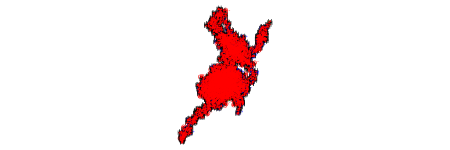

In [49]:
complex = store.get_complex_for_pose(pose_id=poses[0].id)
complex

In [50]:
complex_graph = store.targets[0].graph + poses[0].graph
complex_graph
plotly_molecular_graph(
    complex_graph.nx, 
    colour_nodes_by='entity', 
    colour_edges_by='type',
    plot_title='07dc2a5690da437bb34203e70e1c13a8_3 bound with 7vhy',
    figsize=(1000, 1000),
    node_size_min=10,
    node_size_multiplier=1,
    )

In [30]:
# Check Vina energies of the top 10
grouped_df.head(10)['vina_energy_total']

52    -9.468
132   -9.462
108   -8.946
176   -8.768
18    -8.681
202   -8.597
265   -8.283
143   -8.282
193   -8.151
68    -8.060
Name: vina_energy_total, dtype: float64

/var/folders/cg/vlycgnln3xnfmhcgk1crsfsw0000gn/T/ipykernel_53229/1971933857.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['vina_energy_total'] = filtered_df['vina_energy_total'].round(3)


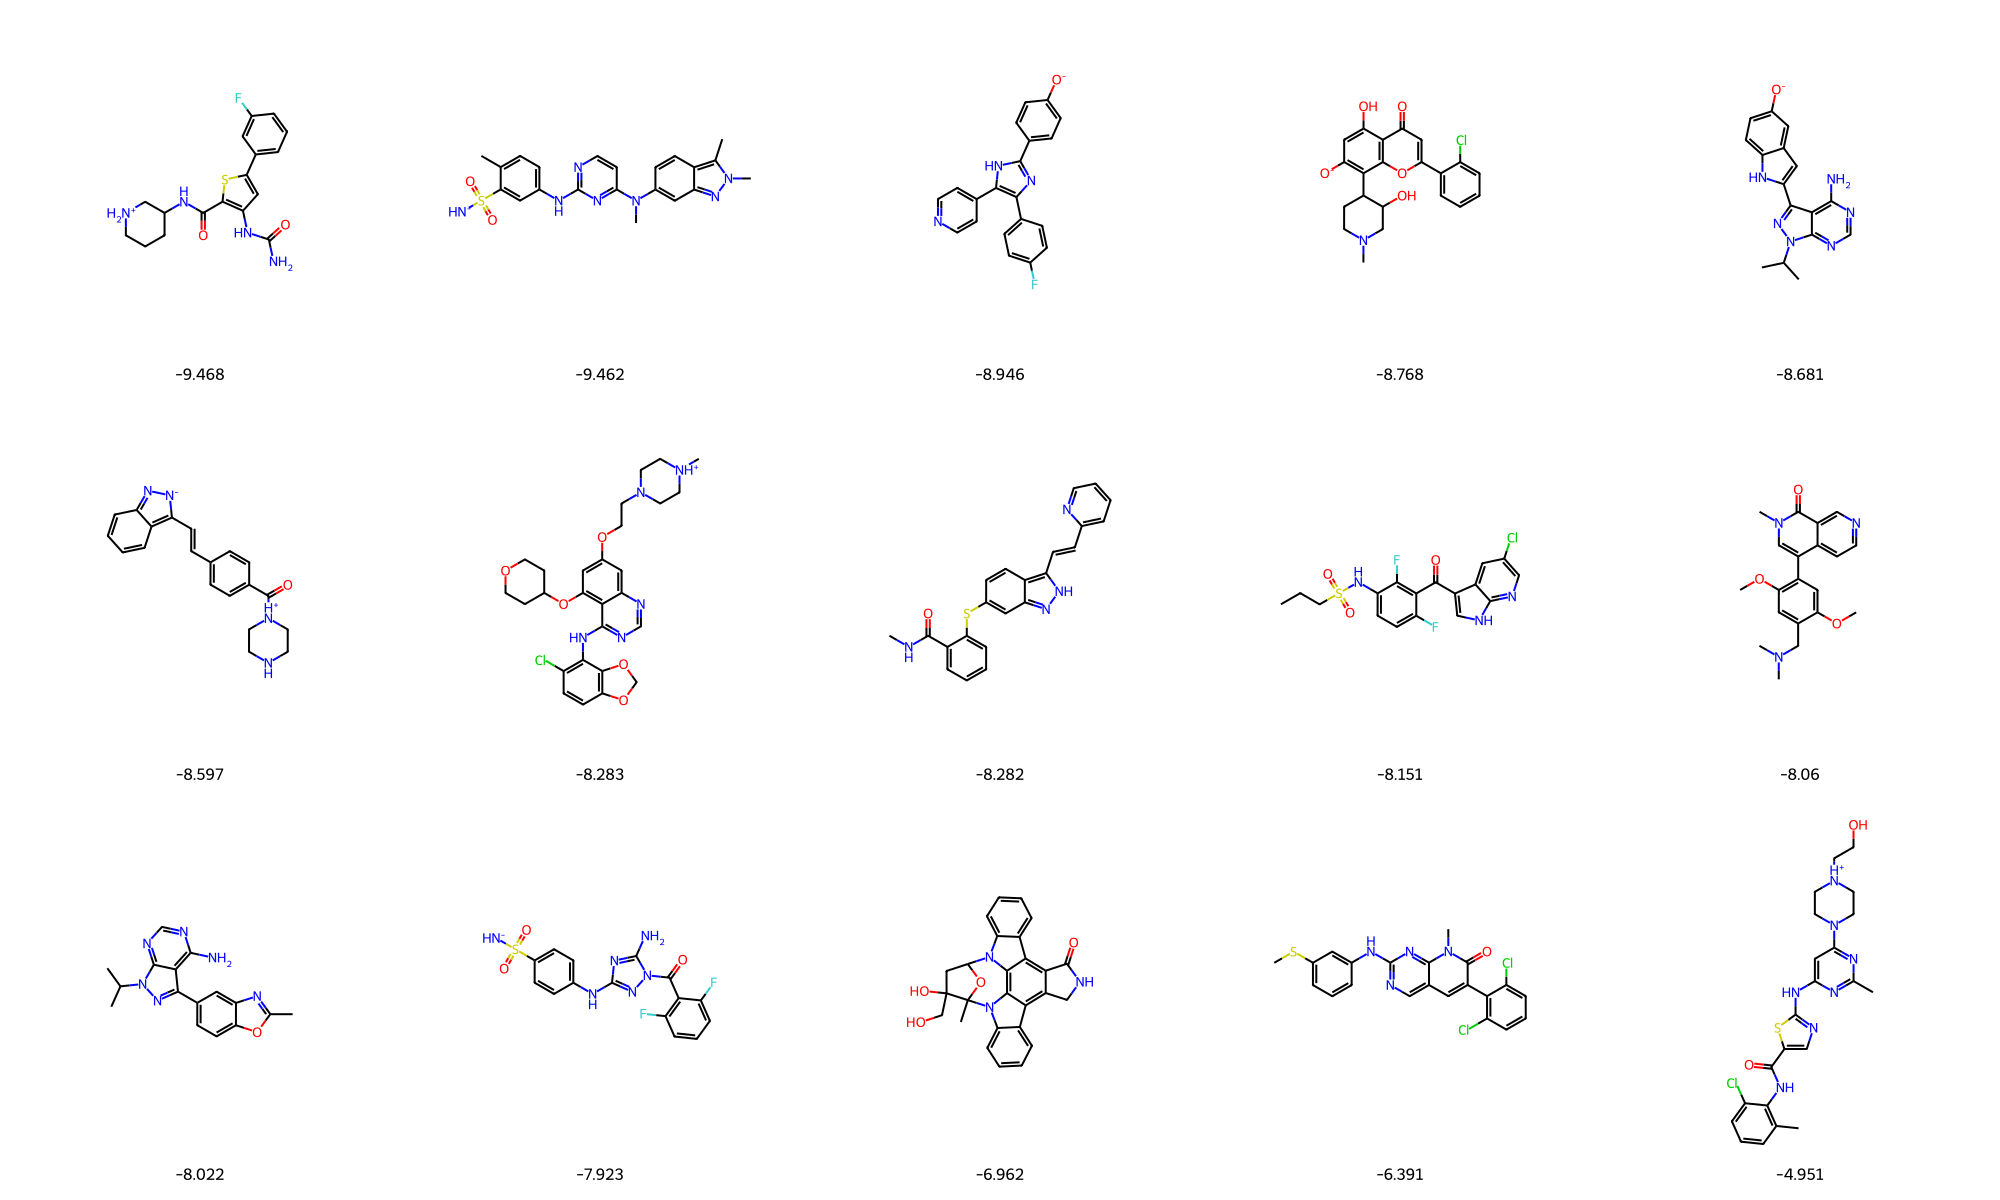

In [19]:
# get the 2D structure of the top 10 moleucles

# Extract the top 10 SMILES strings
top10_smiles = filtered_df['SMILES'].tolist()

# Convert to RDKit molecules
molecules = [Chem.MolFromSmiles(smiles) for smiles in top10_smiles]

# Format the pchembl_value_Mean column to 3 decimal places
filtered_df['vina_energy_total'] = filtered_df['vina_energy_total'].round(3)

# Update legends with formatted values
legends = filtered_df['vina_energy_total'].astype(str).tolist()

# Draw the molecules in a grid and save as PNG
# Draw the molecules in a grid with larger individual images
img = Draw.MolsToGridImage(molecules, molsPerRow=5, subImgSize=(400, 400), legends=legends)  # Increased size
img

In [20]:
with open("../Results/images/Pharmacophore poses.png", "wb") as png:
    png.write(img.data)

In [33]:
from qsprpred.data import MoleculeTable
from qsprpred.data.descriptors.fingerprints import MorganFP
from spock.ml.descriptors import PLIPIFP

mt = MoleculeTable(
    store,
    name="TestMoleculeTable",
    path=store.baseDir,
)
mt.nJobs = os.cpu_count()
mt.chunkSize = 5

In [34]:
mt.addDescriptors(
    [
        PLIPIFP(store.targets[0], n_poses=2)
    ], recalculate=False,
)

qsprpred - ERROR - KekulizeException("Can't kekulize mol.  Unkekulized atoms: 2476 2477 2478 2479 2480")
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/Users/jelle/miniconda3/envs/spock/lib/python3.12/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/jelle/miniconda3/envs/spock/lib/python3.12/site-packages/qsprpred/data/descriptors/sets.py", line 202, in __call__
    values = self.getDescriptors(self.prepMols(mols), props, *args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/jelle/miniconda3/envs/spock/lib/python3.12/site-packages/spock/ml/descriptors.py", line 103, in getDescriptors
    df = calc_plip(
         ^^^^^^^^^^
  File "/Users/jelle/miniconda3/envs/spock/lib/python3.12/site-packages/spock/ml/descriptors.py", line 29, in calc_plip
    Chem.MolToPDBFile(complex, temp_file, flavor=4)
rdkit.Ch

ValueError: Expected a pandas DataFrame from the descriptor calculator. Got <class 'rdkit.Chem.rdchem.KekulizeException'> instead: Can't kekulize mol.  Unkekulized atoms: 2476 2477 2478 2479 2480

In [34]:
descs = mt.getDescriptors()
descs

""
ChemStorage_ID
None
None
None
None
None
...
None
None
None


In [35]:
mt.addDescriptors([MorganFP(radius=3, nBits=2048)], recalculate=True)

In [36]:
mt.getDescriptors()

,MorganFP_0,MorganFP_1,MorganFP_2,MorganFP_3,MorganFP_4,MorganFP_5,MorganFP_6,MorganFP_7,MorganFP_8,MorganFP_9,...,MorganFP_2038,MorganFP_2039,MorganFP_2040,MorganFP_2041,MorganFP_2042,MorganFP_2043,MorganFP_2044,MorganFP_2045,MorganFP_2046,MorganFP_2047
ChemStorage_ID,,,,,,,,,,,,,,,,,,,,,
AAKJLRGGTJKAMG-UHFFFAOYSA-N,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
BCFGMOOMADDAQU-UHFFFAOYSA-N,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
BIIVYFLTOXDAOV-UHFFFAOYSA-N,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
BJFSUDWKXGMUKA-UHFFFAOYSA-N,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
BMGQWWVMWDBQGC-UHFFFAOYSA-N,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
BTIHMVBBUGXLCJ-UHFFFAOYSA-N,False,True,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
CUIHSIWYWATEQL-UHFFFAOYSA-N,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
CVWXJKQAOSCOAB-UHFFFAOYSA-N,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
DKNUPRMJNUQNHR-UHFFFAOYSA-N,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
